## Import Libraries

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas_datareader.data as pdr
import datetime
import numpy as np
import unittest
import pandas as pd
import matplotlib.pyplot as plt
import sys


# seems to be a problem with pandas_datareader
# use this fix to get data from Yahoo! Finance
import fix_yahoo_finance as yf
yf.pdr_override()

# import tensorflow and print info
import tensorflow as tf
gpu_info = "Not found" if not tf.test.gpu_device_name() else tf.test.gpu_device_name() 
print("Tensorflow version %s, GPU: %s" % (tf.__version__,gpu_info))



/Users/Brent/anaconda/envs/stocks/lib/python3.6/site-packages/fix_yahoo_finance/__init__.py:43: DeprecationWarning: 
    Auto-overriding of pandas_datareader's get_data_yahoo() is deprecated and will be removed in future versions.
    Use pdr_override() to explicitly override it.
  DeprecationWarning)
/Users/Brent/anaconda/envs/stocks/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Tensorflow version 1.2.1, GPU: Not found


## Helper Functions

In [4]:
def run_unit_tests(testClass):
    suite = unittest.TestLoader().loadTestsFromTestCase(testClass)
    unittest.TextTestRunner().run(suite)

## Data
Create a class that downloads the stock data and sets up the input/output data

In [11]:
class CreateDataSet:
    
    def __init__(self,symbol):
        self.symbol = symbol
        self.number_of_days = None
        self.train_start_date = None
        self.train_end_date = None
        self.test_start_date = None
        self.test_end_date = None
        self.validation_start_date = None
        self.validation_end_date = None
        self.overall_start_date = None
        self.overall_end_date = None
        self.yahoo_data = None
        self.pandas_df = None
        self.training_df = None
        self.test_df = None
        self.validation_df = None
        self.training_x = None
        self.training_y = None
        self.test_x = None
        self.test_y = None
        self.validation_x = None
        self.validation_y = None
        self.batch_size = None
        self.__data_downloaded = False
        
    # instead of specifying start/end dates for training, test, and validation
    # use all data between a start and end date, shuffle it randomly, and then
    # extract the training, test, and validation sets
    def set_dates(self,start_date,end_date):
        self.__check_date_string_format(start_date)
        self.__check_date_string_format(end_date)
        self.__check_start_date_before_end_date(start_date,end_date)
        self.overall_start_date = start_date
        self.overall_end_date = end_date
        
    def set_training_dates(self,start_date,end_date):
        self.__check_date_string_format(start_date)
        self.__check_date_string_format(end_date)
        self.__check_start_date_before_end_date(start_date,end_date)
        self.train_start_date = start_date
        self.train_end_date = end_date
        
    def set_test_dates(self,start_date,end_date):
        self.__check_date_string_format(start_date)
        self.__check_date_string_format(end_date)
        self.__check_start_date_before_end_date(start_date,end_date)
        self.test_start_date = start_date
        self.test_end_date = end_date
        
    def set_validation_dates(self,start_date,end_date):
        self.__check_date_string_format(start_date)
        self.__check_date_string_format(end_date)
        self.__check_start_date_before_end_date(start_date,end_date)
        self.validation_start_date = start_date
        self.validation_end_date = end_date
        
    def set_batch_size(self,batch_size):
        self.batch_size = batch_size
        
    def download_data(self):
        if self.__use_overall_dates() == False:
            assert self.train_start_date != None, "Training start date not set"
            assert self.train_end_date != None, "Training end date not set"
            assert self.test_start_date != None, "Test start date not set"
            assert self.test_end_date != None, "Test end date not set"
            assert self.validation_start_date != None, "Validation start date not set"
            assert self.validation_end_date != None, "Validation end date not set"
        
        start_date, end_date = self.__calculate_download_start_end_dates()

        self.yahoo_data = self.__download_data_yahoo(self.symbol,start_date,end_date)
        
        assert self.yahoo_data.shape != (0,0), "No data was downloaded"
        
        self.__data_downloaded = True
        
    def create_dataset(self,number_of_days=10):
        
        self.number_of_days = number_of_days
        
        if not self.__data_downloaded:
            self.download_data()
        
        prices = self.yahoo_data['Adj Close']
        
        # fill in missing data
        prices.fillna(method='ffill', inplace=True)
        prices.fillna(method='bfill', inplace=True)
        
        # scale features to make neural network easier to train
        scaled_prices = self.__scale_data(prices)
        
        # input features named X0, X1, X2, ...
        # output feature named Y (this is what we are predicting, tomorrows stock price)
        x_features = [ 'X%d' % (i) for i in range(self.number_of_days)]
        y_feature = ['Y']
        features = x_features + y_feature
        
        df = pd.DataFrame(index=prices.index,columns=features)
        df['Y'] = scaled_prices.shift(-1)
        
        for i in range(self.number_of_days):
            x_feature = "X%d" % (i)
            df[x_feature] = scaled_prices.shift(i)
            
        # trim the dataset to only use dates with enough data
        #
        # example: if number_of_days=10, then first date with enough
        # information will be day 10 (i.e. array index 9)
        #
        # last date will be next to last day in dataset since predicting tommorrows price
        df = df[self.number_of_days-1:-1]
        
        # there shouldn't be any NaN values
        assert df.isnull().values.any() == False, "Dataset contains unexpected NaN values"
                    
        self.pandas_df = df
        
        # split dataset into training/test/validation sets
        
        if self.__use_overall_dates():
            # train/test/validation split 80/10/10
            num_rows = df.shape[0]
            num_train_rows = int(num_rows*0.8)
            num_val_rows = (num_rows - num_train_rows) // 2
            num_test_rows = num_rows - num_train_rows - num_val_rows
            
            self.training_df = df.iloc[:num_train_rows]
            self.test_df = df.iloc[num_train_rows:num_train_rows+num_val_rows]
            self.validation_df = df.iloc[-num_test_rows:]
        else:
            # split based on the dates
            self.training_df = df[self.train_start_date:self.train_end_date]
            self.test_df = df[self.test_start_date:self.test_end_date]
            self.validation_df = df[self.validation_start_date:self.validation_end_date]    
        
        # data as numpy arrays
        self.training_x = self.training_df[x_features].values
        self.training_y = self.training_df[y_feature].values
        self.test_x = self.test_df[x_features].values
        self.test_y = self.test_df[y_feature].values
        self.validation_x = self.validation_df[x_features].values
        self.validation_y = self.validation_df[y_feature].values
        self.x_features = x_features
        
    # function used with neural networks
    # training happens on a batch instead of all the data
    # this function is called multiple times using an iterator to get the next batch
    def get_batches(self):
        assert self.batch_size != None
        
        n_batches = len(self.training_x) // self.batch_size
        assert n_batches > 0, "Batch size %d is too big (resulted in 0 batches)" % (self.batch_size)
        
        x = self.training_x[:n_batches*self.batch_size]
        y = self.training_y[:n_batches*self.batch_size]
        
        for ii in range(0, len(x), self.batch_size):
            yield x[ii:ii+self.batch_size], y[ii:ii+self.batch_size]
        
    def __download_data_yahoo(self,symbol,start_date,end_date):
        data = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)
        return data
    
    def __str_to_datetime(self,date_str):
        return datetime.datetime.strptime(date_str,"%Y-%m-%d")
    
    def __check_date_string_format(self,date_str):
        assert datetime.datetime.strptime(date_str,"%Y-%m-%d"), "Dates must be a string in the format YYYY-MM-DD"
        
    def __check_start_date_before_end_date(self,start_date,end_date):
        start = self.__str_to_datetime(start_date)
        end = self.__str_to_datetime(end_date)
        assert start < end, "Start date must be before the end date"
        
    def __use_overall_dates(self):
        return self.overall_start_date != None and self.overall_end_date != None
        
    def __calculate_download_start_end_dates(self):
        
        if self.__use_overall_dates():
            start_datetime = self.__str_to_datetime(self.overall_start_date)
            end_datetime = self.__str_to_datetime(self.overall_end_date)
        else:        
            train_start = self.__str_to_datetime(self.train_start_date)
            test_start = self.__str_to_datetime(self.test_start_date)
            validation_start = self.__str_to_datetime(self.validation_start_date)
            train_end = self.__str_to_datetime(self.train_end_date)
            test_end = self.__str_to_datetime(self.test_end_date)
            validation_end = self.__str_to_datetime(self.validation_end_date)
        
            start_datetime = min(train_start,test_start,validation_start)
            end_datetime = max(train_end,test_end,validation_end)
        
        start_date = start_datetime.strftime("%Y-%m-%d")
        end_date = end_datetime.strftime("%Y-%m-%d")
          
        return start_date,end_date
    
    def __scale_data(self,data):
        mean, std = data.mean(), data.std()
        self.mean = mean
        self.std = std
        
        scaled_data = (data - mean) / std
        return scaled_data
    
    def unscale_data(self,scaled_data):
        return scaled_data * self.std + self.mean
    


In [10]:
# Test the create data set class
class CreateDataSetTest(unittest.TestCase):
        
    def test_set_dates(self):
        dataset = CreateDataSet('SPY')
        dataset.set_training_dates(start_date="2010-01-01",end_date="2011-01-01")
        dataset.set_test_dates(start_date="2010-01-01",end_date="2011-01-01")
        dataset.set_validation_dates(start_date="2010-01-01",end_date="2011-01-01")
        
    def test_set_dates_not_str(self):
        dataset = CreateDataSet('SPY')
        
        with self.assertRaises(Exception):
            dataset.set_training_dates(start_date=datetime.datetime(2010,1,1),end_date="2011-01-01")
            
        with self.assertRaises(Exception):
            dataset.set_training_dates(start_date="2010-01-01",end_date=datetime.datetime(2011,1,1))
            
        with self.assertRaises(Exception):
            dataset.set_test_dates(start_date=datetime.datetime(2010,1,1),end_date="2011-01-01")
            
        with self.assertRaises(Exception):
            dataset.set_test_dates(start_date="2010-01-01",end_date=datetime.datetime(2011,1,1))
            
        with self.assertRaises(Exception):
            dataset.set_validation_dates(start_date=datetime.datetime(2010,1,1),end_date="2011-01-01")
            
        with self.assertRaises(Exception):
            dataset.set_validation_dates(start_date="2010-01-01",end_date=datetime.datetime(2011,1,1))
            
    def test_set_dates_bad_str_format(self):
        dataset = CreateDataSet('SPY')
        
        with self.assertRaises(Exception):
            dataset.set_training_dates(start_date="01-01-2011",end_date="2011-01-01")
            
        with self.assertRaises(Exception):
            dataset.set_training_dates(start_date="2010-01-01",end_date="01-01-2011")
            
        with self.assertRaises(Exception):
            dataset.set_test_dates(start_date="01-01-2011",end_date="2011-01-01")
            
        with self.assertRaises(Exception):
            dataset.set_test_dates(start_date="2010-01-01",end_date="01-01-2011")
            
        with self.assertRaises(Exception):
            dataset.set_validation_dates(start_date="01-01-2011",end_date="2011-01-01")
            
        with self.assertRaises(Exception):
            dataset.set_validation_dates(start_date="2010-01-01",end_date="01-01-2011")
            
    def test_set_dates_start_date_after_end_date(self):
        dataset = CreateDataSet('SPY')
        
        with self.assertRaises(Exception):
            dataset.set_training_dates(start_date="2011-01-02",end_date="2011-01-01")
            
        with self.assertRaises(Exception):
            dataset.set_test_dates(start_date="2011-01-02",end_date="2011-01-01")
            
        with self.assertRaises(Exception):
            dataset.set_validation_dates(start_date="2011-01-02",end_date="2011-01-01")
            
    def test_download_start_end_dates_1(self):
        dataset = CreateDataSet('SPY')
        dataset.set_training_dates(start_date="2010-01-04",end_date="2010-06-01")
        dataset.set_test_dates(start_date="2011-01-04",end_date="2011-06-01")
        dataset.set_validation_dates(start_date="2012-01-04",end_date="2012-06-01")        
        dataset.download_data()
        
        # (start_date,end_date) should be (training_start,validation_end)
        self.__verify_start_end_date(dataset.yahoo_data,expected_start="2010-01-04",expected_end="2012-06-01")
        
    def test_download_start_end_dates_2(self):
        dataset = CreateDataSet('SPY')
        dataset.set_test_dates(start_date="2010-01-04",end_date="2010-06-01")
        dataset.set_validation_dates(start_date="2011-01-04",end_date="2011-06-01")
        dataset.set_training_dates(start_date="2012-01-04",end_date="2012-06-01")        
        dataset.download_data()
        
        # (start_date,end_date) should be (test_start,training_end)
        self.__verify_start_end_date(dataset.yahoo_data,expected_start="2010-01-04",expected_end="2012-06-01")
        
    def test_download_start_end_dates_3(self):
        dataset = CreateDataSet('SPY')
        dataset.set_validation_dates(start_date="2010-01-04",end_date="2010-06-01")
        dataset.set_training_dates(start_date="2011-01-04",end_date="2011-06-01")
        dataset.set_test_dates(start_date="2012-01-04",end_date="2012-06-01")        
        dataset.download_data()
        
        # (start_date,end_date) should be (validation_start,test_end)
        self.__verify_start_end_date(dataset.yahoo_data,expected_start="2010-01-04",expected_end="2012-06-01")
        
    def test_download_overall_start_end_dates(self):
        dataset = CreateDataSet('SPY')
        dataset.set_dates(start_date="2010-01-04",end_date="2012-06-01")
        dataset.download_data()
        self.__verify_start_end_date(dataset.yahoo_data,expected_start="2010-01-04",expected_end="2012-06-01")
        
    def __verify_start_end_date(self,dataframe,expected_start,expected_end):
        start_date, end_date = dataframe.index[0], dataframe.index[-1]
        start_date = start_date.strftime("%Y-%m-%d")
        end_date = end_date.strftime("%Y-%m-%d")
        
        self.assertEqual(start_date,expected_start)
        self.assertEqual(end_date,expected_end)
        
    def test_create_dataset(self):
        dataset = CreateDataSet('SPY')
        dataset.set_training_dates(start_date="2010-01-04",end_date="2010-06-01")
        dataset.set_test_dates(start_date="2011-01-04",end_date="2011-06-01")
        dataset.set_validation_dates(start_date="2012-01-04",end_date="2012-06-01")        
        dataset.create_dataset()
        
        # check for 10 x features and 1 y feature
        self.assertEqual(dataset.training_x.shape[1],10)
        self.assertEqual(dataset.training_y.shape[1],1)
        self.assertEqual(dataset.test_x.shape[1],10)
        self.assertEqual(dataset.test_y.shape[1],1)
        self.assertEqual(dataset.validation_x.shape[1],10)
        self.assertEqual(dataset.validation_y.shape[1],1)
        
        # check dates
        self.__check_data_in_date_range(dataset.training_df,start_date="2010-01-04",end_date="2010-06-01")
        self.__check_data_in_date_range(dataset.test_df,start_date="2011-01-04",end_date="2011-06-01")
        self.__check_data_in_date_range(dataset.validation_df,start_date="2012-01-04",end_date="2012-06-01")
        
    def test_create_dataset_overall_dates(self):
        dataset = CreateDataSet('SPY')
        dataset.set_dates(start_date="2010-01-04",end_date="2012-06-01")
        dataset.create_dataset()
        
        # check for 10 x features and 1 y feature
        #self.assertEqual(dataset.training_x.shape[1],10)
        #self.assertEqual(dataset.training_y.shape[1],1)
        #self.assertEqual(dataset.test_x.shape[1],10)
        #self.assertEqual(dataset.test_y.shape[1],1)
        #self.assertEqual(dataset.validation_x.shape[1],10)
        #self.assertEqual(dataset.validation_y.shape[1],1)
        
    def __check_data_in_date_range(self,df,start_date,end_date):
        dates = df.index
        start_timestamp = pd.to_datetime(start_date)        
        end_timestamp = pd.to_datetime(end_date)
        
        for date in dates:
            self.assertTrue(date >= start_timestamp)
            self.assertTrue(date <= end_timestamp)
            
    def test_get_batches(self):
        dataset = CreateDataSet('SPY')
        dataset.set_training_dates(start_date="2010-01-04",end_date="2010-06-01")
        dataset.set_test_dates(start_date="2011-01-04",end_date="2011-06-01")
        dataset.set_validation_dates(start_date="2012-01-04",end_date="2012-06-01")        
        dataset.create_dataset()
        
        dataset.set_batch_size(32)
        for x_batch, y_batch in dataset.get_batches():
            self.assertEqual(x_batch.shape,(32,10))
            self.assertEqual(y_batch.shape,(32,1))
            
    
        
run_unit_tests(CreateDataSetTest)

[*********************100%***********************]  1 of 1 downloaded

.

[*********************100%***********************]  1 of 1 downloaded> <ipython-input-9-db3691974117>(127)create_dataset()
-> num_rows = df.shape[0]
(Pdb) n
> <ipython-input-9-db3691974117>(128)create_dataset()
-> num_train_rows = int(num_rows*0.8)
(Pdb) n
> <ipython-input-9-db3691974117>(129)create_dataset()
-> num_val_rows = (num_rows - num_train_rows) // 2
(Pdb) n
> <ipython-input-9-db3691974117>(130)create_dataset()
-> num_test_rows = num_rows - num_train_rows - num_val_rows
(Pdb) n
> <ipython-input-9-db3691974117>(132)create_dataset()
-> self.training_df = df.iloc[:num_train_rows]
(Pdb) num_train_rows, num_val_rows, num_test_rows
(479, 60, 60)
(Pdb) num_rows
599
(Pdb) 479+60+60
599
(Pdb) l
127  	            num_rows = df.shape[0]
128  	            num_train_rows = int(num_rows*0.8)
129  	            num_val_rows = (num_rows - num_train_rows) // 2
130  	            num_test_rows = num_rows - num_train_rows - num_val_rows
131  	
132  ->	            self.training_df = df.iloc[:num_tr

.

[*********************100%***********************]  1 of 1 downloaded

.

[*********************100%***********************]  1 of 1 downloaded

.

[*********************100%***********************]  1 of 1 downloaded

.

[*********************100%***********************]  1 of 1 downloaded

.

[*********************100%***********************]  1 of 1 downloaded

.....
----------------------------------------------------------------------
Ran 11 tests in 137.631s

OK


## Create your model
Setup whatever model you plan to use for price prediction. i.e. neural network, linear regression, etc.

In [5]:
class NeuralNetwork:
    
    def __init__(self):
        self.learning_rate = None
        self.number_of_inputs = None
        self.keep_prob = None
        self.epochs = None
        self.dataset = None
        self.optimizer = None
        self.cost = None
        self.graph = None
        self.output = None
        self.run_until_loss_achieved = False
        self.max_epochs = 0
        self.average_last_n_samples = 0
        self.loss_threshold = 0
        self.hidden_layers = []
        
    def add_inputs(self,number_of_inputs):
        self.number_of_inputs = number_of_inputs
        
    def add_hidden_layer(self,number_of_nodes,dropout=False):
        self.hidden_layers.append((number_of_nodes,dropout))
            
    def set_learning_rate(self,learning_rate):
        self.learning_rate = learning_rate
        
    def set_keep_probability(self,keep_prob):
        self.keep_probability = keep_prob
        
    def set_epochs(self,epochs):
        self.run_until_loss_achieved = False
        self.epochs = epochs
        
    # instead of running for a specific number of epochs, 
    # keep training until the loss value is acceptable
    def stop_when_average_validation_loss_below(self,loss_threshold,last_n_samples=5,max_epochs=10000):
        self.run_until_loss_achieved = True
        self.loss_threshold = loss_threshold
        self.max_epochs = max_epochs
        self.average_last_n_samples = last_n_samples
        
    def set_dataset(self,dataset):
        self.dataset = dataset
        
    def build_model(self):
        
        tf.reset_default_graph()
        self.graph = tf.Graph()
        
        with self.graph.as_default():
        
            inputs = tf.placeholder(tf.float32,[None,self.number_of_inputs],name="inputs")
            targets = tf.placeholder(tf.float32,[None,1],name="targets")
            keep_prob = tf.placeholder(tf.float32,name="keep_prob")
        
            # add hidden layers
            layer = inputs
            for i in range(len(self.hidden_layers)):
                num_nodes, dropout = self.hidden_layers[i]

                layer = tf.layers.dense(layer,num_nodes,activation=tf.nn.relu)
            
                if dropout:
                    layer = tf.nn.dropout(layer,keep_prob)
            
            
            # last layer predict the price
            output = tf.layers.dense(layer,1,activation=None,name="output")
        
            # setup loss function and optimizer
            loss = tf.nn.l2_loss(targets-output)
            cost = tf.reduce_mean(loss)
            optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(cost)
        
            # save variables to be used later
            self.inputs = inputs
            self.targets = targets
            self.keep_prob = keep_prob
            self.cost = cost
            self.optimizer = optimizer
            self.output = output
        
    def train(self,print_updates=True):
        
        self.__reset_stats()
        num_epochs = self.__calculate_number_of_epochs()
        
        with self.graph.as_default():
            saver = tf.train.Saver()
        
        with tf.Session(graph=self.graph) as sess:
            
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(num_epochs):
                
                batch_i = 0
                for batch_x, batch_y in self.dataset.get_batches():
                    
                    sess.run(self.optimizer,feed_dict={self.inputs:batch_x, self.targets:batch_y, self.keep_prob:self.keep_probability})
                    train_loss, val_loss = self.__save_stats(sess,batch_x,batch_y)
                    
                    if print_updates:
                        #print("Epoch %d Batch %d:  Training Loss: %0.4f, Validation Loss %0.4f" % (epoch,batch_i,train_loss,val_loss))
                        sys.stdout.write("\rEpoch %d Batch %d:  Training Loss: %0.4f, Validation Loss %0.4f" % (epoch,batch_i,train_loss,val_loss))
                        sys.stdout.flush()
                        
                    batch_i += 1
                    
                if self.__terminate_training():
                    break
                    
            # save the number of epochs run
            self.number_of_epochs_run = epoch
             
            if print_updates:
                print("")
            
            # run final model on the test set
            test_loss = self.__calculate_test_loss(sess)
            print("Training Complete.  Test Set Loss: %0.4f" % (test_loss))
            self.test_loss = test_loss
            
            # save the model
            save_path = saver.save(sess, "checkpoints/nn.ckpt")
    
    def predict(self,input_x):
        
        x = np.array([input_x])
        
        with self.graph.as_default():
            saver = tf.train.Saver()

        with tf.Session(graph=self.graph) as sess:
            saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
            
            output_y = sess.run(self.output, feed_dict={self.inputs:x,self.keep_prob:1})
            
        return output_y
    
    def predict_sequence(self,initial_input_x,x_features,length):
        
        x = np.array([initial_input_x])
        sequence = []
        
        with self.graph.as_default():
            saver = tf.train.Saver()

        with tf.Session(graph=self.graph) as sess:
            saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
            
            for i in range(length):
                
                # predict one data sample
                y = sess.run(self.output, feed_dict={self.inputs:x,self.keep_prob:1})[0][0]
                sequence.append(y)
                
                # prepare data for the next sample
                x = self.__prepare_next_input(x,x_features,y)
                
        return np.array(sequence)
            
    def plot_losses(self,title="",start_index=0):
        x = range(len(self.train_losses))
        plt.plot(x[start_index:],self.train_losses[start_index:], label='Training loss')
        plt.plot(x[start_index:],self.validation_losses[start_index:], label='Validation loss')
        plt.legend()
        plt.title(title)
        _ = plt.ylim()
                    
    def __reset_stats(self):
        self.train_losses = []
        self.validation_losses = []
        
    def __calculate_number_of_epochs(self):
        if self.run_until_loss_achieved:
            return self.max_epochs
        
        return self.epochs
        
    def __calculate_train_loss(self,session,batch_x,batch_y):
        train_loss = session.run(self.cost, feed_dict={self.inputs:batch_x,self.targets:batch_y,self.keep_prob:1})
        return train_loss
    
    def __calculate_validation_loss(self,session):
        validation_loss = session.run(self.cost, feed_dict={self.inputs:self.dataset.validation_x,self.targets:self.dataset.validation_y,self.keep_prob:1})
        return validation_loss
    
    def __calculate_test_loss(self,session):
        test_loss = session.run(self.cost, feed_dict={self.inputs:self.dataset.test_x,self.targets:self.dataset.test_y,self.keep_prob:1})
        return test_loss
                       
    def __save_stats(self,session,batch_x,batch_y):
        train_loss = self.__calculate_train_loss(session,batch_x,batch_y)
        validation_loss = self.__calculate_validation_loss(session)
        self.train_losses.append(train_loss)
        self.validation_losses.append(validation_loss)
        return train_loss, validation_loss
    
    def __prepare_next_input(self,current_x,x_feature_map,predicted_y):
        
        new_x = np.zeros(current_x.shape,dtype=current_x.dtype)
        
        num_features = len(x_feature_map)
        
        # check out the feature map to ensure the names are as expected
        # i.e. X0, X1, X2, ...
        # and create an index lookup
        lookup_index = dict()
        for i in range(num_features):
            feature = "X%d" % (i)
            assert feature in x_feature_map
            lookup_index[feature] = i
            
        # shift all inputs by 1 day except for the last feature
        for i in range(-1,num_features-2,-1):
            old_feature = "X%d" % (i)
            new_feature = "X%d" % (i+1)
            
            print("%s = %s" % (new_feature,old_feature))
            
            old_i = lookup_index[old_feature]
            new_i = lookup_index[new_feature]
            
            new_x[new_i] = current_x[old_i]
        
        x0_index = lookup_index["X0"]
        new_x[x0_index] = predicted_y
        
        return new_x
    
    def __terminate_training(self):
        if self.run_until_loss_achieved == False:
            return False
        
        last_n_losses = self.validation_losses[-self.average_last_n_samples:]
        average_validation_loss = np.mean(last_n_losses)
        
        return average_validation_loss < self.loss_threshold  
        
        

## Hyperparameters
Create a class to help try out different hyperparameters

In [6]:
class Parameters:
    
    def __init__(self,initial_seed=None):
        if initial_seed == None:
            self.set_seed(0)
        else:
            self.set_seed(initial_seed)

        self.params = dict()
        self.values = dict()
        
    def choose_params(self):
        
        self.__set_random_seed()
        
        self.values = dict()
        
        for param in self.params:
            
            param_info = self.params[param]
            param_type = param_info[0]
            
            if param_type == "scalar":
                _, value = param_info
                self.values[param] = value
                
            elif param_type == "random_choice":
                _, choices = param_info
                value = np.random.choice(choices)
                self.values[param] = value
                
            elif param_type == "random_float":
                _, start, end = param_info
                value = np.random.uniform(start,end)                
                self.values[param] = value
                
            elif param_type == "random_int":
                _, start, end = param_info
                value = np.random.randint(start,end+1) 
                self.values[param] = value
                
            else:
                assert False, "Unexpected parameter type %s" % (param_type)
    
    def set_seed(self,seed):
        self.seed = seed
        self.increment_seed = False
    
    def scalar(self,param_name,value):
        self.params[param_name] = ("scalar",value)
        
    def random_choice(self,param_name,choices):
        self.params[param_name] = ("random_choice",choices)
    
    def random_float(self,param_name,start_value,end_value):
        self.params[param_name] = ("random_float",start_value,end_value)
    
    def random_int(self,param_name,start_value,end_value):
        self.params[param_name] = ("random_int",start_value,end_value)
        
    def print_chosen_values(self,seed=None):

        # save current seed
        if seed != None:
            saved_seed = self.seed
            self.set_seed(seed)
            self.choose_params()
            
        # print the values
        parameters = sorted(self.values.keys())
        
        for param in parameters:
            print("%s: %s" % (param,self.values[param]))
        print("")
        
        # restore seed
        if seed != None:
            self.set_seed(saved_seed)
            self.choose_params()
        
        
        
    def __set_random_seed(self):        
        if self.increment_seed:
            self.seed += 1
        self.increment_seed = True
            
        np.random.seed(self.seed)

## Helper functions for displaying hyperparameter search results

In [7]:
def top_results(number,results):
    values = results.values()
    train_loss_sorted = sorted(values,key=lambda x:x[1])
    validation_loss_sorted = sorted(values,key=lambda x:x[2])
    test_loss_sorted = sorted(values,key=lambda x:x[3])
    
    top_train_loss = train_loss_sorted[:number]
    top_validation_loss = validation_loss_sorted[:number]
    top_test_loss = test_loss_sorted[:number]
    
    return top_train_loss, top_validation_loss, top_test_loss

def print_loss_results(top_loss,title):
    print("")
    print(title)
    for i in range(len(top_loss)):
        seed, train_loss, val_loss, test_loss, epochs = top_loss[i]
        print("Seed %d (%d epochs): Train=%0.4f, Validation=%0.4f, Test=%0.4f" % (seed, epochs, train_loss, val_loss, test_loss))
        
def print_parameters(params,seed,title=""):
    print(title)
    params.print_chosen_values(seed)
    
def smooth_loss(losses,last_num_points=5):
    data = np.array(losses[-last_num_points:])
    return data.mean()
    

## Run the Neural Networks
Choose different hyperparameters and run them in the neural network.<br>
Keep track of the best results

In [8]:
smooth = True   # Ensure that the model we pick has a consistent loss instead of randomly being a low value

# setup the dataset
dataset = CreateDataSet('SPY')
dataset.set_training_dates(start_date="2008-01-01",end_date="2010-01-01")
dataset.set_test_dates(start_date="2011-01-04",end_date="2011-06-01")
dataset.set_validation_dates(start_date="2012-01-04",end_date="2012-06-01") 
dataset.set_batch_size(32)

# setup the parameters to vary
params = Parameters()
params.random_choice('learning_rate',[0.1,0.01,0.001,0.0001])
params.scalar('keep_prob',0.5)
params.random_choice('hidden_layers',[1,2,3])
params.random_int('number_of_days',2,100)
params.random_int('number_of_nodes',20,100)

# setup and run the neural networks
results = dict()

for i in range(10):
     
    # choose the parameters
    params.set_seed(i)
    params.choose_params()
    params.print_chosen_values()
    
    number_of_days = params.values['number_of_days']
    learning_rate = params.values['learning_rate']
    keep_prob = params.values['keep_prob']
    num_nodes_1st_layer = params.values['number_of_nodes']
    num_layers = params.values['hidden_layers']
    
    # create the dataset
    dataset.create_dataset(number_of_days=number_of_days)
    
    # build the neural network
    nn = NeuralNetwork()
    nn.set_learning_rate(learning_rate)
    nn.set_keep_probability(keep_prob)
    nn.stop_when_average_validation_loss_below(1.0,max_epochs=1000)
    nn.set_dataset(dataset)
    
    nn.add_inputs(number_of_inputs=number_of_days)
    
    num_nodes = num_nodes_1st_layer
    for layer in range(num_layers):
        nn.add_hidden_layer(number_of_nodes=num_nodes)
        num_nodes = num_nodes // 2
    
    nn.build_model() 
    
    # train the model
    nn.train(print_updates=True)
    
    # save results
    # seed number, train loss, validation loss, test loss
    if smooth:
        smooth_train_loss = smooth_loss(nn.train_losses)
        smooth_val_loss = smooth_loss(nn.validation_losses)
        
        results[i] = (i,smooth_train_loss, smooth_val_loss, nn.test_loss,nn.number_of_epochs_run)
    else:
        results[i] = (i,nn.train_losses[-1], nn.validation_losses[-1], nn.test_loss, self.number_of_epochs_run)
        

hidden_layers: 2
keep_prob: 0.5
learning_rate: 0.1
number_of_days: 66
number_of_nodes: 87

[*********************100%***********************]  1 of 1 downloaded

/Users/Brent/anaconda/envs/stocks/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch 999 Batch 12:  Training Loss: 2.8217, Validation Loss 257.0870122500
Training Complete.  Test Set Loss: 177.2448
hidden_layers: 1
keep_prob: 0.5
learning_rate: 0.01
number_of_days: 74
number_of_nodes: 29

Epoch 76 Batch 12:  Training Loss: 0.3268, Validation Loss 0.8355876
Training Complete.  Test Set Loss: 0.9250
hidden_layers: 2
keep_prob: 0.5
learning_rate: 0.1
number_of_days: 74
number_of_nodes: 42

Epoch 999 Batch 12:  Training Loss: 3.4132, Validation Loss 261.926669
Training Complete.  Test Set Loss: 181.2749
hidden_layers: 1
keep_prob: 0.5
learning_rate: 0.001
number_of_days: 5
number_of_nodes: 76

Epoch 16 Batch 14:  Training Loss: 0.2015, Validation Loss 0.9638
Training Complete.  Test Set Loss: 0.4417
hidden_layers: 3
keep_prob: 0.5
learning_rate: 0.001
number_of_days: 57
number_of_nodes: 89

Epoch 48 Batch 13:  Training Loss: 0.0501, Validation Loss 0.96146
Training Complete.  Test Set Loss: 0.7796
hidden_layers: 3
keep_prob: 0.5
learning_rate: 0.0001
number_of_days: 

## Print out the top results

In [9]:
top_train, top_val, top_test = top_results(5,results)
print_loss_results(top_train,"Top 5 Training Loss:")
print_loss_results(top_val,"Top 5 Validation Loss:")
print_loss_results(top_test,"Top 5 Test Loss:")


Top 5 Training Loss:
Seed 5 (999 epochs): Train=0.1099, Validation=1.6336, Test=1.4879
Seed 7 (255 epochs): Train=0.1541, Validation=0.9984, Test=0.6149
Seed 6 (584 epochs): Train=0.1635, Validation=0.8793, Test=0.8629
Seed 3 (16 epochs): Train=0.1777, Validation=0.9574, Test=0.4417
Seed 4 (48 epochs): Train=0.2023, Validation=0.9576, Test=0.7796

Top 5 Validation Loss:
Seed 9 (23 epochs): Train=1.1218, Validation=0.7917, Test=0.8652
Seed 1 (76 epochs): Train=0.4246, Validation=0.8350, Test=0.9250
Seed 6 (584 epochs): Train=0.1635, Validation=0.8793, Test=0.8629
Seed 8 (23 epochs): Train=9.0067, Validation=0.9171, Test=0.3805
Seed 3 (16 epochs): Train=0.1777, Validation=0.9574, Test=0.4417

Top 5 Test Loss:
Seed 8 (23 epochs): Train=9.0067, Validation=0.9171, Test=0.3805
Seed 3 (16 epochs): Train=0.1777, Validation=0.9574, Test=0.4417
Seed 7 (255 epochs): Train=0.1541, Validation=0.9984, Test=0.6149
Seed 4 (48 epochs): Train=0.2023, Validation=0.9576, Test=0.7796
Seed 6 (584 epochs): 

In [10]:
## Print out the top results hyperparemeters
print_parameters(params,seed=top_train[0][0],title="Top Training Loss Parameters")
print_parameters(params,seed=top_val[0][0],title="Top Validation Loss Parameters")
print_parameters(params,seed=top_test[0][0],title="Top Test Loss Parameters")

Top Training Loss Parameters
hidden_layers: 3
keep_prob: 0.5
learning_rate: 0.0001
number_of_days: 63
number_of_nodes: 36

Top Validation Loss Parameters
hidden_layers: 1
keep_prob: 0.5
learning_rate: 0.001
number_of_days: 56
number_of_nodes: 76

Top Test Loss Parameters
hidden_layers: 1
keep_prob: 0.5
learning_rate: 0.0001
number_of_days: 7
number_of_nodes: 28



## Rerun the network with the best performance so we can get more details results


In [11]:
# get the hyperparameters
top_test_seed = top_test[0][0]
params.set_seed(top_test_seed)
params.choose_params()

number_of_days = params.values['number_of_days']
learning_rate = params.values['learning_rate']
keep_prob = params.values['keep_prob']
num_nodes_1st_layer = params.values['number_of_nodes']
num_layers = params.values['hidden_layers']

# setup the data
dataset.create_dataset(number_of_days=number_of_days)
    
# build the neural network
nn = NeuralNetwork()
nn.set_learning_rate(learning_rate)
nn.set_keep_probability(keep_prob)
nn.stop_when_average_validation_loss_below(1.0,max_epochs=1000)
nn.set_dataset(dataset)
    
nn.add_inputs(number_of_inputs=number_of_days)
    
num_nodes = num_nodes_1st_layer
for layer in range(num_layers):
    nn.add_hidden_layer(number_of_nodes=num_nodes)
    num_nodes = num_nodes // 2
    
nn.build_model() 

# train the network
nn.train(print_updates=True)
        

/Users/Brent/anaconda/envs/stocks/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch 16 Batch 14:  Training Loss: 2.4162, Validation Loss 0.87723
Training Complete.  Test Set Loss: 0.5427


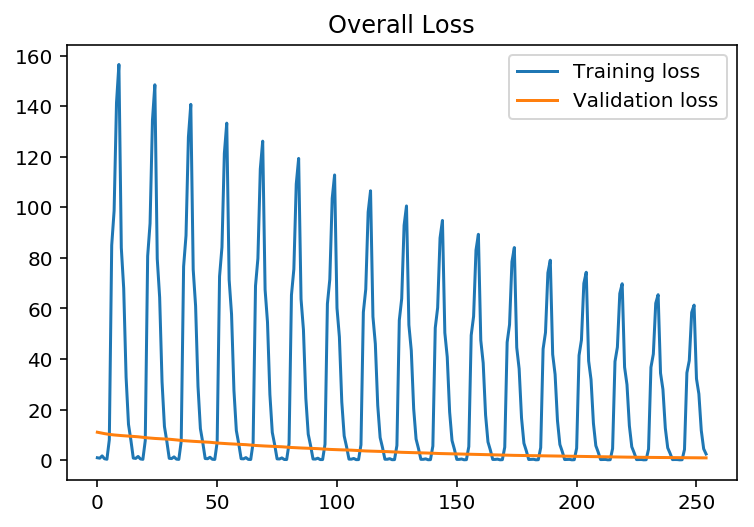

In [12]:
# plot results
nn.plot_losses(title="Overall Loss")

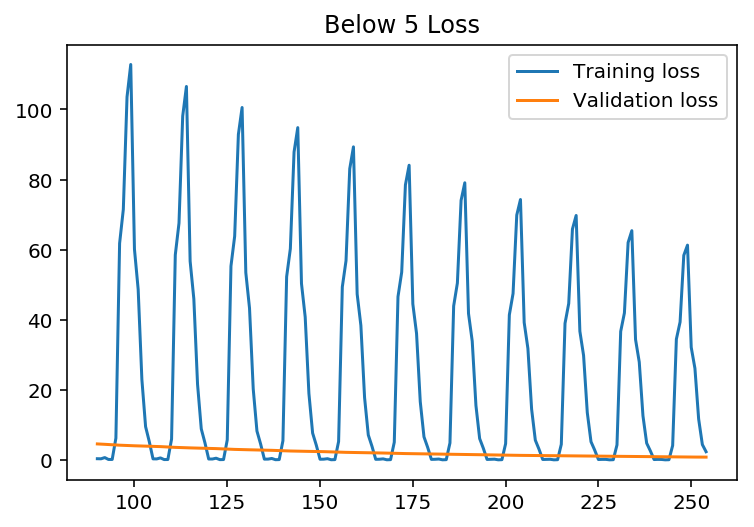

In [13]:
# show losses in better detail

# set starting point where train loss goes below 5 for at least 10 samples
def find_starting_point(losses,loss_target=5,consecutive_values=10):
    start = 0
    counter = 0
    
    for i,loss in enumerate(losses):
        start = i
        if loss < loss_target:
            counter += 1
        else:
            counter = 0
        
        if counter >= consecutive_values:
            break
    return start
    
start_index = find_starting_point(nn.validation_losses,loss_target=5)
nn.plot_losses(title="Below 5 Loss",start_index=start_index)

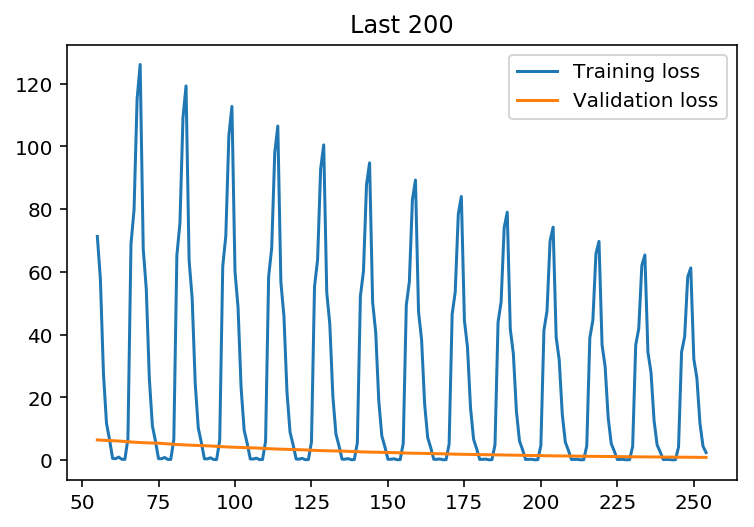

In [14]:
nn.plot_losses(title="Last 200",start_index=-200)

In [15]:
# predict the first data point (use to show that prediction working)
x = dataset.test_x[0]
y = nn.predict(x)
target_y = dataset.test_y[0]

y_price = dataset.unscale_data(y)
target_y_price = dataset.unscale_data(target_y)

print("Input:")
print(x)
print("Prediction: %0.4f (Price $%0.4f)" % (y,y_price))
print("Target    : %0.4f (Price $%0.4f)" % (target_y,target_y_price))


INFO:tensorflow:Restoring parameters from checkpoints/nn.ckpt
Input:
[ 0.68759719  0.69145998  0.61971288  0.61805705  0.62909429  0.62412635
  0.61419281]
Prediction: 0.6326 (Price $110.3033)
Target    : 0.7240 (Price $111.7537)


INFO:tensorflow:Restoring parameters from checkpoints/nn.ckpt


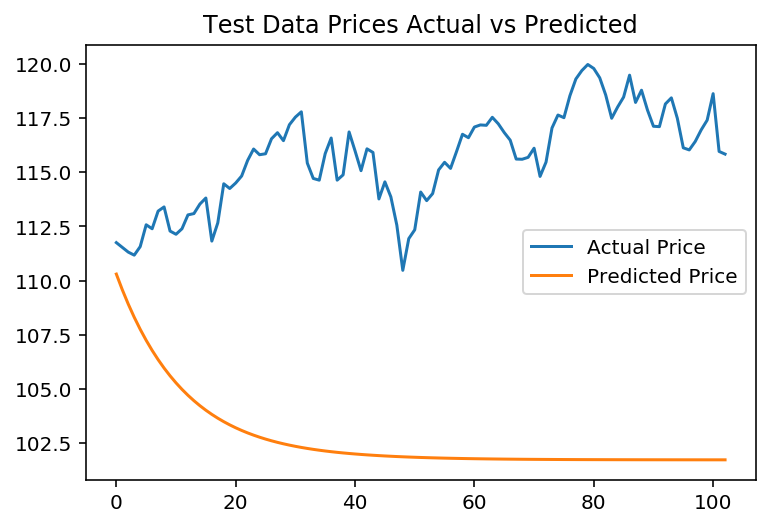

In [16]:
# predict the price over the test set starting from the initial test data point
x = dataset.test_x[0]
num_predictions = len(dataset.test_x)

y = nn.predict_sequence(x,dataset.x_features,length=num_predictions)

y_prices = dataset.unscale_data(y)
test_y_prices = dataset.unscale_data(dataset.test_y)

# plot the prices
plt.plot(test_y_prices, label='Actual Price')
plt.plot(y_prices, label='Predicted Price')
plt.legend()
plt.title("Test Data Prices Actual vs Predicted")
_ = plt.ylim()


INFO:tensorflow:Restoring parameters from checkpoints/nn.ckpt


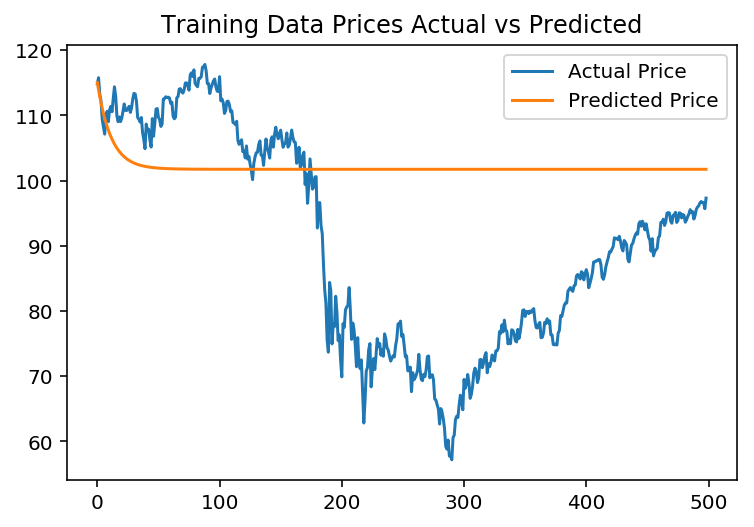

In [17]:
# predict the price over the training set starting from the initial training data point
x = dataset.training_x[0]
num_predictions = len(dataset.training_x)

y = nn.predict_sequence(x,dataset.x_features,length=num_predictions)

y_prices = dataset.unscale_data(y)
test_y_prices = dataset.unscale_data(dataset.training_y)

# plot the prices
plt.plot(test_y_prices, label='Actual Price')
plt.plot(y_prices, label='Predicted Price')
plt.legend()
plt.title("Training Data Prices Actual vs Predicted")
_ = plt.ylim()